<a href="https://colab.research.google.com/github/mdominguezd/PyTorch_Training/blob/main/Transform_Ready_To_Use_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geemap -q
!pip install pycrs -q
!pip install geedim -q

In [2]:
!wget -O Planet.zip https://www.dropbox.com/scl/fi/pz1ksyrw29zsjvbdld096/PlanetTanzania.zip?rlkey=j4jtvmkfpnouuo8dod94zar1h&dl=0

--2023-09-10 14:05:58--  https://www.dropbox.com/scl/fi/pz1ksyrw29zsjvbdld096/PlanetTanzania.zip?rlkey=j4jtvmkfpnouuo8dod94zar1h
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/pz1ksyrw29zsjvbdld096/PlanetTanzania.zip?rlkey=j4jtvmkfpnouuo8dod94zar1h [following]
--2023-09-10 14:05:59--  https://www.dropbox.com/e/scl/fi/pz1ksyrw29zsjvbdld096/PlanetTanzania.zip?rlkey=j4jtvmkfpnouuo8dod94zar1h
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc95fbc0dc3a3c417c366ebf015b.dl.dropboxusercontent.com/cd/0/inline/CDeAopNg7hRrL-74iXh8kj3UIPXlT8n0smYyIllAeT2sKcdXcxJ0VGCfMcFLn8Xsy6HXf3Bk1vdXaCFDNfrCHqJ9PIqcBgJQ4jZVPB5RLoAu_TDgdXjkLlMutUCP-vz_L9b4EdrwgTKP8HslcUhAnuKs/file# [following]
--2023-09-10 14:05:59--  https://uc9

In [4]:
import ee
import geemap
import os
import numpy as np
import geopandas as gpd
from zipfile import ZipFile
import torchvision.transforms as T
# from skimage import io
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import rasterio
from rasterio.plot import show

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with ZipFile("Planet.zip", 'r') as zipped:
    zipped.extractall(path="./")

In [ ]:
patch_size = 512

overlap = patch_size // 2

conversion = T.ToTensor()

image_ids = [1,3,5]
img_folder = 'PlanetTanzania'

imgs = []

img = io.imread(os.path.join(img_folder, 'TanzaniaStudyArea.tif')).astype(np.float32)

img = img/np.max(img) # Normalize all bands to a random value

#Crop into patches, following a regularly sampled grid.
#i and j are defined as the center of the patch to crop.
for i in np.arange(patch_size//2, img.shape[0] - patch_size // 2, overlap):
  for j in np.arange(patch_size//2, img.shape[1] - patch_size // 2, overlap):
    #Crop the image and the ground truth into patch around (i,j) and save
    #them in self.imgs and self.GTs arrays.
    #For the image, note that we are taking the three channels (using ":")
    #for the 3rd dimension, and we do the conversion to tensor.
    im_patch = img[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2,:]
    imgs.append(conversion(im_patch))


Working on image 1
Working on image 3
Working on image 5


In [1]:
img

NameError: ignored

In [ ]:
imgs[0][:3].shape

torch.Size([3, 512, 512])

In [23]:
def plot(img):
  plt.imshow(img[:3].flip([-3]).permute(1,2,0))

In [7]:
class Tanzania_Dataset(Dataset):
  def __init__(self, img_folder, patch_size=512): #GT_folder
    self.imgs = []
    # self.GTs = []

    overlap = patch_size // 2

    conversion = T.ToTensor()

    #Load the tile and the corresponding ground truth.
    img = io.imread(os.path.join(img_folder, 'TanzaniaStudyArea.tif')).astype(np.float32)

    img = img/np.max(img) # Normalize all bands to a random value

    #Crop into patches, following a regularly sampled grid.
    #i and j are defined as the center of the patch to crop.
    for i in np.arange(patch_size//2, img.shape[0] - patch_size // 2, overlap):
      for j in np.arange(patch_size//2, img.shape[1] - patch_size // 2, overlap):
        #Crop the image and the ground truth into patch around (i,j) and save
        #them in self.imgs and self.GTs arrays.
        #For the image, note that we are taking the three channels (using ":")
        #for the 3rd dimension, and we do the conversion to tensor.
        im_patch = img[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2,:]
        self.imgs.append(conversion(im_patch))

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx. Since we pre-loaded the images
    #and the ground truths, we just have to return the corresponding sample.
    img = self.imgs[idx].float()
    # GT = self.GTs[idx]

    #We also need to return the ground truth as a tensor
    return img

In [ ]:
tnz_DS = Tanzania_Dataset('PlanetTanzania')

In [ ]:
tnz_DS.__len__()

2401

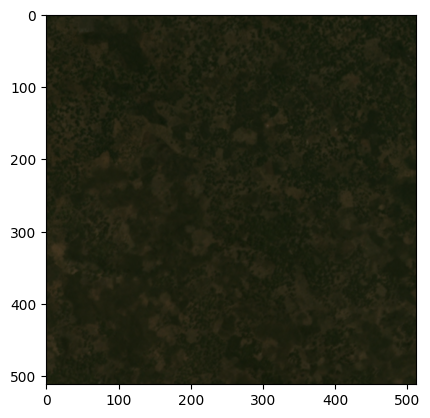

In [ ]:
plot(tnz_DS.__getitem__(151))

In [2]:
conversion = T.ToTensor()
with rasterio.open('PlanetTanzania/TanzaniaStudyArea.tif') as src:
  img = src.read()

In [ ]:
patch_size = 512
img_folder = 'PlanetTanzania'

overlap = patch_size // 2

conversion = T.ToTensor()

#Load the tile and the corresponding ground truth.
# img = io.imread(os.path.join(img_folder, 'TanzaniaStudyArea.tif'))
with rasterio.open(os.path.join(img_folder, 'TanzaniaStudyArea.tif')) as src:
  img = src.read()
# .astype(np.float32)

img = img/np.max(img) # Normalize all bands to a random value

#Crop into patches, following a regularly sampled grid.
#i and j are defined as the center of the patch to crop.
for i in np.arange(patch_size//2, img.shape[0] - patch_size // 2, overlap):
  for j in np.arange(patch_size//2, img.shape[1] - patch_size // 2, overlap):
    #Crop the image and the ground truth into patch around (i,j) and save
    #them in self.imgs and self.GTs arrays.
    #For the image, note that we are taking the three channels (using ":")
    #for the 3rd dimension, and we do the conversion to tensor.
    im_patch = img[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2,:]
    self.imgs.append(conversion(im_patch.astype(np.float32)))

In [3]:
class Tanzania_Dataset(Dataset):
  def __init__(self, img_folder, patch_size=512): #GT_folder
    self.imgs = []
    # self.GTs = []

    overlap = patch_size // 2

    conversion = T.ToTensor()

    #Load the tile and the corresponding ground truth.
    # img = io.imread(os.path.join(img_folder, 'TanzaniaStudyArea.tif'))
    with rasterio.open(os.path.join(img_folder, 'TanzaniaStudyArea.tif')) as src:
      img = src.read()
    # .astype(np.float32)

    img = img/np.max(img) # Normalize all bands to a random value

    #Crop into patches, following a regularly sampled grid.
    #i and j are defined as the center of the patch to crop.
    for i in np.arange(patch_size//2, img.shape[0] - patch_size // 2, overlap):
      for j in np.arange(patch_size//2, img.shape[1] - patch_size // 2, overlap):
        #Crop the image and the ground truth into patch around (i,j) and save
        #them in self.imgs and self.GTs arrays.
        #For the image, note that we are taking the three channels (using ":")
        #for the 3rd dimension, and we do the conversion to tensor.
        im_patch = img[i - patch_size//2:i + patch_size // 2, j - patch_size // 2:j + patch_size // 2,:]
        self.imgs.append(conversion(im_patch.astype(np.float32)))

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    #__getitem__ asks for the sample number idx. Since we pre-loaded the images
    #and the ground truths, we just have to return the corresponding sample.
    img = self.imgs[idx].float()
    # GT = self.GTs[idx]

    #We also need to return the ground truth as a tensor
    return img

In [ ]:
tz = Tanzania_Dataset('PlanetTanzania')

In [28]:
img.shape

(4, 2086, 2066)

In [17]:
img.shape[0]

4